# Dogs vs. Cats Classifier

In this notebook, I will be looking at how to load images and use them to train a neural network, by using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

<img src='assets/dog_cat.png'>

I'll use this dataset to train a neural network that can differentiate between cats and dogs.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

The easiest way to load image data is with `datasets.ImageFolder` from `torchvision`. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has it's own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. I've also split it into a training set and test set.

### Transforms

When loading in the data with `ImageFolder`, I need to define some transforms. For example, the images are different sizes but I'll need them to all be the same size for training. I'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. I'll combine all these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence.

### Data Loaders

With the `ImageFolder` loaded, I have to pass it to a `DataLoader`. The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. Additionally, I can set various parameters like the batch size and if the data is shuffled after each epoch. Here `dataloader` is a generator, so in order to get data out of it, I need to loop through it or convert it to an iterator and call `next()`.

### Data Augmentation

A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc. I'll also typically want to normalize images with `transforms.Normalize`, by passing in a list of means and list of standard deviations, then the color channels are normalized like so

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Subtracting `mean` centers the data around zero and dividing by `std` squishes the values to be between -1 and 1. Normalising helps keep the network work weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

In [6]:
data_dir = r'C:\Users\IMI\MisDocsOrdenador\Cursos\Udacity\Airbus Udacity Artificial Intelligence Nanodegree\Deep Learning Neural Networks\Dogs vs Cats Classifier\Cat_Dog_data'

# Define transforms for the training data and testing data
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.Resize(280),
    transforms.CenterCrop(240),
    transforms.RandomVerticalFlip(p=0.8),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize(280),
    transforms.CenterCrop(240),
    transforms.ToTensor(),
])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

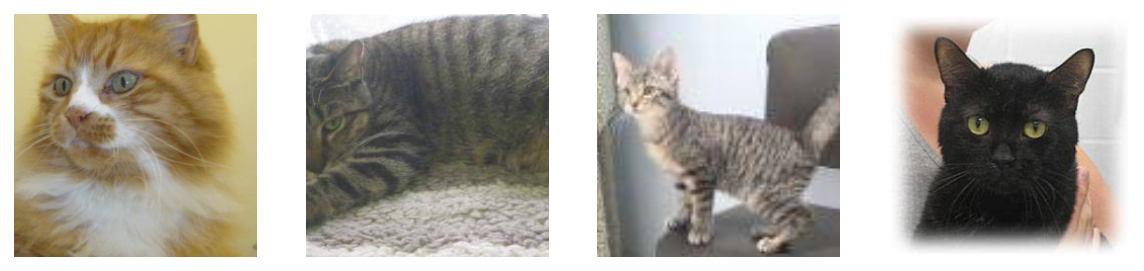

In [11]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

# change this to the trainloader or testloader 
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)

We are now able to load data for training and testing. Now, I can try building a network that can classify cats vs dogs. I will first try with a fully-connected layer, although this is quite a bit more complicated than before with the MNIST and Fashion-MNIST datasets. To be honest, it probably won't work, no matter how deep. These images have three color channels and at a higher resolution.

In [12]:
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [23]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(172800, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [24]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 14.474..  Test Loss: 3768.060..  Test Accuracy: 0.506
Epoch: 2/30..  Training Loss: 35.907..  Test Loss: 2819.319..  Test Accuracy: 0.506
Epoch: 3/30..  Training Loss: 35.724..  Test Loss: 3090.869..  Test Accuracy: 0.506
Epoch: 4/30..  Training Loss: 26.401..  Test Loss: 4.705..  Test Accuracy: 0.506
Epoch: 5/30..  Training Loss: 0.301..  Test Loss: 4.619..  Test Accuracy: 0.506
Epoch: 6/30..  Training Loss: 0.350..  Test Loss: 2.040..  Test Accuracy: 0.506
Epoch: 7/30..  Training Loss: 11.885..  Test Loss: 2.874..  Test Accuracy: 0.506
Epoch: 8/30..  Training Loss: 0.475..  Test Loss: 2.003..  Test Accuracy: 0.506
Epoch: 9/30..  Training Loss: 0.438..  Test Loss: 3.595..  Test Accuracy: 0.506
Epoch: 10/30..  Training Loss: 0.423..  Test Loss: 1.884..  Test Accuracy: 0.506
Epoch: 11/30..  Training Loss: 0.452..  Test Loss: 1.702..  Test Accuracy: 0.506
Epoch: 12/30..  Training Loss: 0.494..  Test Loss: 1.575..  Test Accuracy: 0.506
Epoch: 13/30..  Trainin

KeyboardInterrupt: 

It is clear that a fully-connected network will not work well on this data. I will next have to try a convolutional network, or even use an already existing model with transfer learning.